## Text Classification with Naive Bayes, Logistic Regression, and SVM

Let's start with importing the necessary modules and libraries

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import string

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [23]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to C:\Users\erkam/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\erkam/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\erkam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Part I. Load and Explore the Dataset

In [24]:
df = pd.read_csv("../resources/text class/Full-Economic-News-DFE-839861.csv", encoding = "ISO-8859-1")
df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,positivity,positivity:confidence,relevance,relevance:confidence,articleid,date,headline,positivity_gold,relevance_gold,text
0,842613455,False,finalized,3,12/5/15 17:48,3.0,0.6400,yes,0.640,wsj_398217788,8/14/91,Yields on CDs Fell in the Latest Week,NaN,NaN,"NEW YORK -- Yields on most certificates of deposit offered by major banks dropped more than a tenth of a percentage point in the latest week, reflecting the overall decline in short-term interest rates.</br></br>On small-denomination, or ""consumer,"" CDs sold directly by banks, the average yield on six-month deposits fell to 5.49% from 5.62% in the week ended yesterday, according to an 18-bank survey by Banxquote Money Markets, a Wilmington, Del., information service.</br></br>On three-month ""consumer"" deposits, the average yield sank to 5.29% from 5.42% the week before, according to Banxquote. Two banks in the Banxquote survey, Citibank in New York and CoreStates in Pennsylvania, are paying less than 5% on threemonth small-denomination CDs.</br></br>Declines were somewhat smaller on five-year consumer CDs, which eased to 7.37% from 7.45%, Banxquote said.</br></br>Yields on three-month and six-month Treasury bills sold at Monday's auction plummeted more than a fifth of a percentage point from the previous week, to 5.46% and 5.63%, respectively."
1,842613456,False,finalized,3,12/5/15 16:54,NaN,NaN,no,1.000,wsj_399019502,8/21/07,The Morning Brief: White House Seeks to Limit Child Insurance Program,NaN,NaN,"The Wall Street Journal Online</br></br>The Morning Brief, a look at the day's biggest news, is emailed to subscribers by 7 a.m. every business day. Sign up for the e-mail here.</br></br>On Friday evening, with Congress out of town on its summer recess and Americans heading into a mid-August weekend, the Bush administration sent a message to the states: The federal government will make it tougher for a national children's insurance program to cover the offspring of middle-income families.</br></br>The State Children's Health Insurance Program was created in 1997 to help children whose families couldn't afford insurance but didn't qualify for Medicaid, and administration officials tell the New York Times that the changes are aimed at returning the program to its low- income focus and assuring it didn't become a replacement for private insurance. Administration point man Dennis Smith wrote to state officials saying there would be new restrictions on the District of Columbia and the 18 states -- including California and New York -- that extend or plan to extend coverage for children whose families make more than 250% of Federal poverty levels. For a family of three that 250% is $42,900, and for a family of four it's $51,625. Under the new limits, a child from a family making more would have to spend one year uninsured before qualifying, and any state that wants to extend coverage would have to assure Washington that at least 95% of children eligible for SCHIP or Medicaid are enrolled in one of the programs. But as the Associated Press reports, no state can currently make such assurances.</br></br>Rachel Klein, deputy director of health policy for advocacy group Families USA, tells the AP that since many families above the 250% threshold can't afford private insurance, ""the effect of this policy is to have more uninsured kids."" Ann Clemency Kohler, deputy commissioner of human services in New Jersey, tells the Times the changes ""will cause havoc with our program and could jeopardize coverage for thousands of children."" States have already been imposing waiting periods and taking other steps to prevent parents from moving their children from private insurance to SCHIP, which currently serves some 6.6 million children, the Washington Post notes. The administration's new restrictions come as the program, which expires at the end of next month if Congress doesn't reauthorize it, is the subject of a larger pol

In [25]:
df.shape

(8000, 15)

In [26]:
df.relevance.value_counts(normalize=True)

relevance
no          0.821375
yes         0.177500
not sure    0.001125
Name: proportion, dtype: float64

In [27]:
df = df[df.relevance != "not sure"]
df.shape

(7991, 15)

In [28]:
df.relevance = df.relevance.map({"yes":1, "no":0})
df.relevance.unique()

array([1, 0], dtype=int64)

### Part II. Text Pre-processing

Create a cleaner function for the textual features.

In [29]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_tokenize_lemmatize(doc):
    doc = doc.lower()
    doc = doc.replace("</br>", " ") 
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    doc = " ".join([token for token in doc.split() if token not in stop_words])

    tokens = word_tokenize(doc)
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return " ".join(tokens) 

In [30]:
df.text = df.text.apply(clean_tokenize_lemmatize)
df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,positivity,positivity:confidence,relevance,relevance:confidence,articleid,date,headline,positivity_gold,relevance_gold,text
0,842613455,False,finalized,3,12/5/15 17:48,3.0,0.6400,1,0.640,wsj_398217788,8/14/91,Yields on CDs Fell in the Latest Week,NaN,NaN,new york yield certificate deposit offered major bank dropped tenth percentage point latest week reflecting overall decline shortterm interest rate smalldenomination consumer cd sold directly bank average yield sixmonth deposit fell week ended yesterday according bank survey banxquote money market wilmington del information service threemonth consumer deposit average yield sank week according banxquote two bank banxquote survey citibank new york corestates pennsylvania paying less threemonth smalldenomination cd decline somewhat smaller fiveyear consumer cd eased banxquote said yield threemonth sixmonth treasury bill sold monday auction plummeted fifth percentage point previous week respectively
1,842613456,False,finalized,3,12/5/15 16:54,NaN,NaN,0,1.000,wsj_399019502,8/21/07,The Morning Brief: White House Seeks to Limit Child Insurance Program,NaN,NaN,wall street journal online morning brief look day biggest news emailed subscriber every business day sign email friday evening congress town summer recess american heading midaugust weekend bush administration sent message state federal government make tougher national childrens insurance program cover offspring middleincome family state childrens health insurance program created help child whose family couldnt afford insurance didnt qualify medicaid administration official tell new york time change aimed returning program low income focus assuring didnt become replacement private insurance administration point man dennis smith wrote state official saying would new restriction district columbia state including california new york extend plan extend coverage child whose family make federal poverty level family three family four new limit child family making would spend one year uninsured qualifying state want extend coverage would assure washington least child eligible schip medicaid enrolled one program associated press report state currently make assurance rachel klein deputy director health policy advocacy group family usa tell ap since many family threshold cant afford private insurance effect policy uninsured kid ann clemency kohler deputy commissioner human service new jersey tell time change cause havoc program could jeopardize coverage thousand child state already imposing waiting period taking step prevent parent moving child private insurance schip currently serf million child washington post note administration new restriction come program expires end next month congress doesnt reauthorize subject larger political fight pit white house democrat republican congress state capital
2,842613457,False,finalized,3,12/5/15 1:59,NaN,NaN,0,1.000,wsj_398284048,11/14/91,Banking Bill Negotiators Set Compromise --- Plan to Widen Banks' Entry To Securities Business Is Dropped as Vote Nears,NaN,NaN,washington effort achieve banking reform senate negotiator bush administration agreed drop effort allow bank expand security business compromise one several senate banking committee pursuing remove obstacle banking bill face senate start voting measure perhaps today latest version house banking bill also drop administration proposal broaden bank entry security business last night house began second attempt pas banking bill failing last week part disagreement allow bank security business house adopted voice vote provision would replenish bank deposit insurance fund tighten bank regulation trim scope deposit insurance restrict federal reserve board ability keep sick bank alive loan house delayed today vote amendment allow bank branch nationwide final passage banking bill give house leadership administration time drum support bill house speaker thomas foley wash working hard wi

### Part III. Modeling

Split the dataset into testing and training sets.

In [31]:
x = df.text
y = df.relevance

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=58)

Vectorize the train and test sets.

In [32]:
vect = CountVectorizer(max_features=5000)
x_train_dtm = vect.fit_transform(x_train)
x_test_dtm = vect.transform(x_test)

Train the Naive Bayes Classifier.

In [33]:
nb = MultinomialNB()
nb.fit(x_train_dtm, y_train)

MultinomialNB()

In [37]:
print(classification_report(y_test, nb.predict(x_test_dtm)))

              precision    recall  f1-score   support

           0       0.91      0.71      0.80      1302
           1       0.35      0.69      0.46       297

    accuracy                           0.71      1599
   macro avg       0.63      0.70      0.63      1599
weighted avg       0.80      0.71      0.74      1599



Visualize the confusion matrix.

In [38]:
cm = confusion_matrix(y_test, nb.predict(x_test_dtm))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_normalized

array([[0.70967742, 0.29032258],
       [0.31313131, 0.68686869]])

In [39]:
def plot_conf_matrix(cm):
    plt.clf()
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Irrelevant", "Relevant"], yticklabels=["Irrelevant", "Relevant"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

<Figure size 640x480 with 0 Axes>

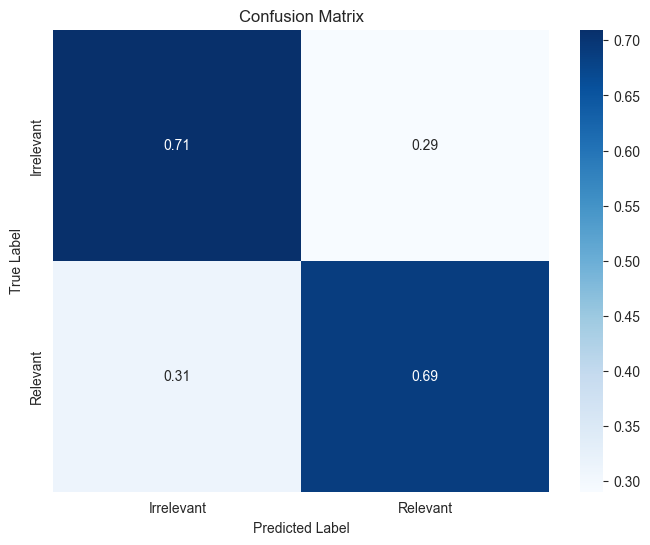

In [40]:
plot_conf_matrix(cm_normalized)

Now create a Logistic Regression model.

In [42]:
logreg = LogisticRegression(class_weight="balanced")
logreg.fit(x_train_dtm, y_train)
print(classification_report(y_test, logreg.predict(x_test_dtm)))

              precision    recall  f1-score   support

           0       0.85      0.79      0.82      1302
           1       0.29      0.38      0.33       297

    accuracy                           0.71      1599
   macro avg       0.57      0.58      0.57      1599
weighted avg       0.74      0.71      0.73      1599



<Figure size 640x480 with 0 Axes>

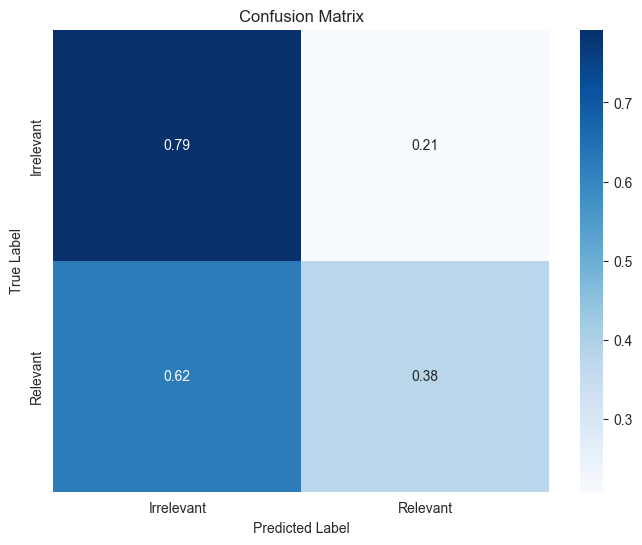

In [43]:
cm2 = confusion_matrix(y_test, logreg.predict(x_test_dtm))
cm2_normalized = cm2.astype('float') / cm2.sum(axis=1)[:, np.newaxis]
plot_conf_matrix(cm2_normalized)

Lets try SVM.

In [44]:
vect = CountVectorizer(max_features=1000)
x_train_dtm = vect.fit_transform(x_train)
x_test_dtm = vect.transform(x_test)

svm = LinearSVC(class_weight="balanced")
svm.fit(x_train_dtm, y_train)

y_pred = svm.predict(x_test_dtm)

<Figure size 640x480 with 0 Axes>

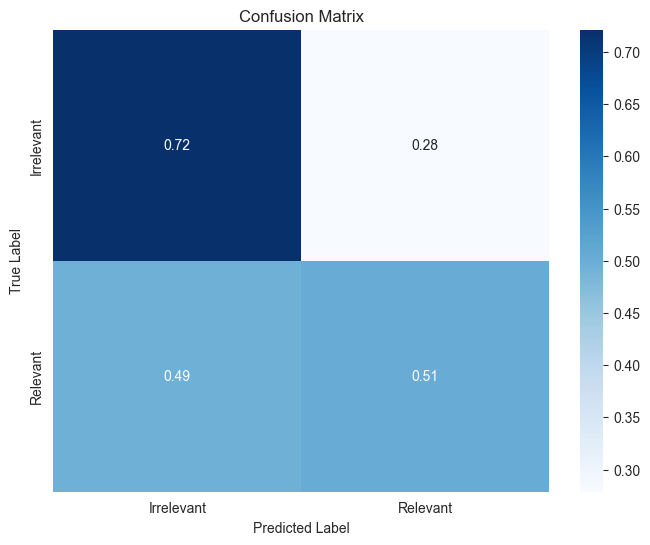

In [45]:
cm3 = confusion_matrix(y_test, svm.predict(x_test_dtm))
cm3_normalized = cm3.astype('float') / cm3.sum(axis=1)[:, np.newaxis]
plot_conf_matrix(cm3_normalized)